## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось


## Важно 2 (0 - 0.15 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы.



## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. 
В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например дополнительные лоссы для стабилизации, WGAN-GP, а не GAN/WGAN+clip)


In [1]:
import numpy as np
import torchvision

import torch
from torch import nn
from torch.nn import functional as F

from tqdm.notebook import tqdm
from IPython.display import clear_output


import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload

%autoreload 2

! pip install wandb

     |████████████████████████████████| 2.0MB 16.3MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 133kB 53.6MB/s 
     |████████████████████████████████| 163kB 51.5MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=81a0a45f419536571848c219a41231641168a0c9196e5074430d096a72ae6268
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=446598427734e9af14cc7934179ce8ed2414658de43dc8e15676c2b4f3f9e605
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


В этом домашнем задании мы будем работать с Celeba. Celeba - это уже известный вам датасет состоящий из фотографий селеб в их привычной местности:

In [2]:
size = 64

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((size, size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    torchvision.transforms.RandomHorizontalFlip()
])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! gdown --id 1F96x4LDbsTZGMMq81fZr7aduJCe8N95O

Downloading...
From: https://drive.google.com/uc?id=1F96x4LDbsTZGMMq81fZr7aduJCe8N95O
To: /content/celeba.zip
2.73GB [00:38, 71.4MB/s]


In [5]:
import zipfile

path_to_zip = "/content/celeba.zip"


with zipfile.ZipFile(path_to_zip, 'r') as file:
    file.extractall(path='/content')

In [6]:
! ls celeba


celeba


In [7]:
# celeba = torchvision.datasets.CelebA('celeba', target_type='attr', transform=transforms, download=True)
celeba = torchvision.datasets.CelebA('/content/celeba', target_type='attr', transform=transforms, download=False)
len(celeba)

162770

In [8]:
n = len(celeba)
t = int(n * 0.95)
train_set, val_set = torch.utils.data.random_split(celeba, [t, n - t])

b_s = 64

celeba_dataloader = torch.utils.data.DataLoader(train_set, 64, shuffle=True)
celeba_val_dataloader = torch.utils.data.DataLoader(val_set, 1, shuffle=False)

In [9]:
cuda_num = 0
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'

In [10]:
index2attr = {i:j for i, j in enumerate(celeba.attr_names)}

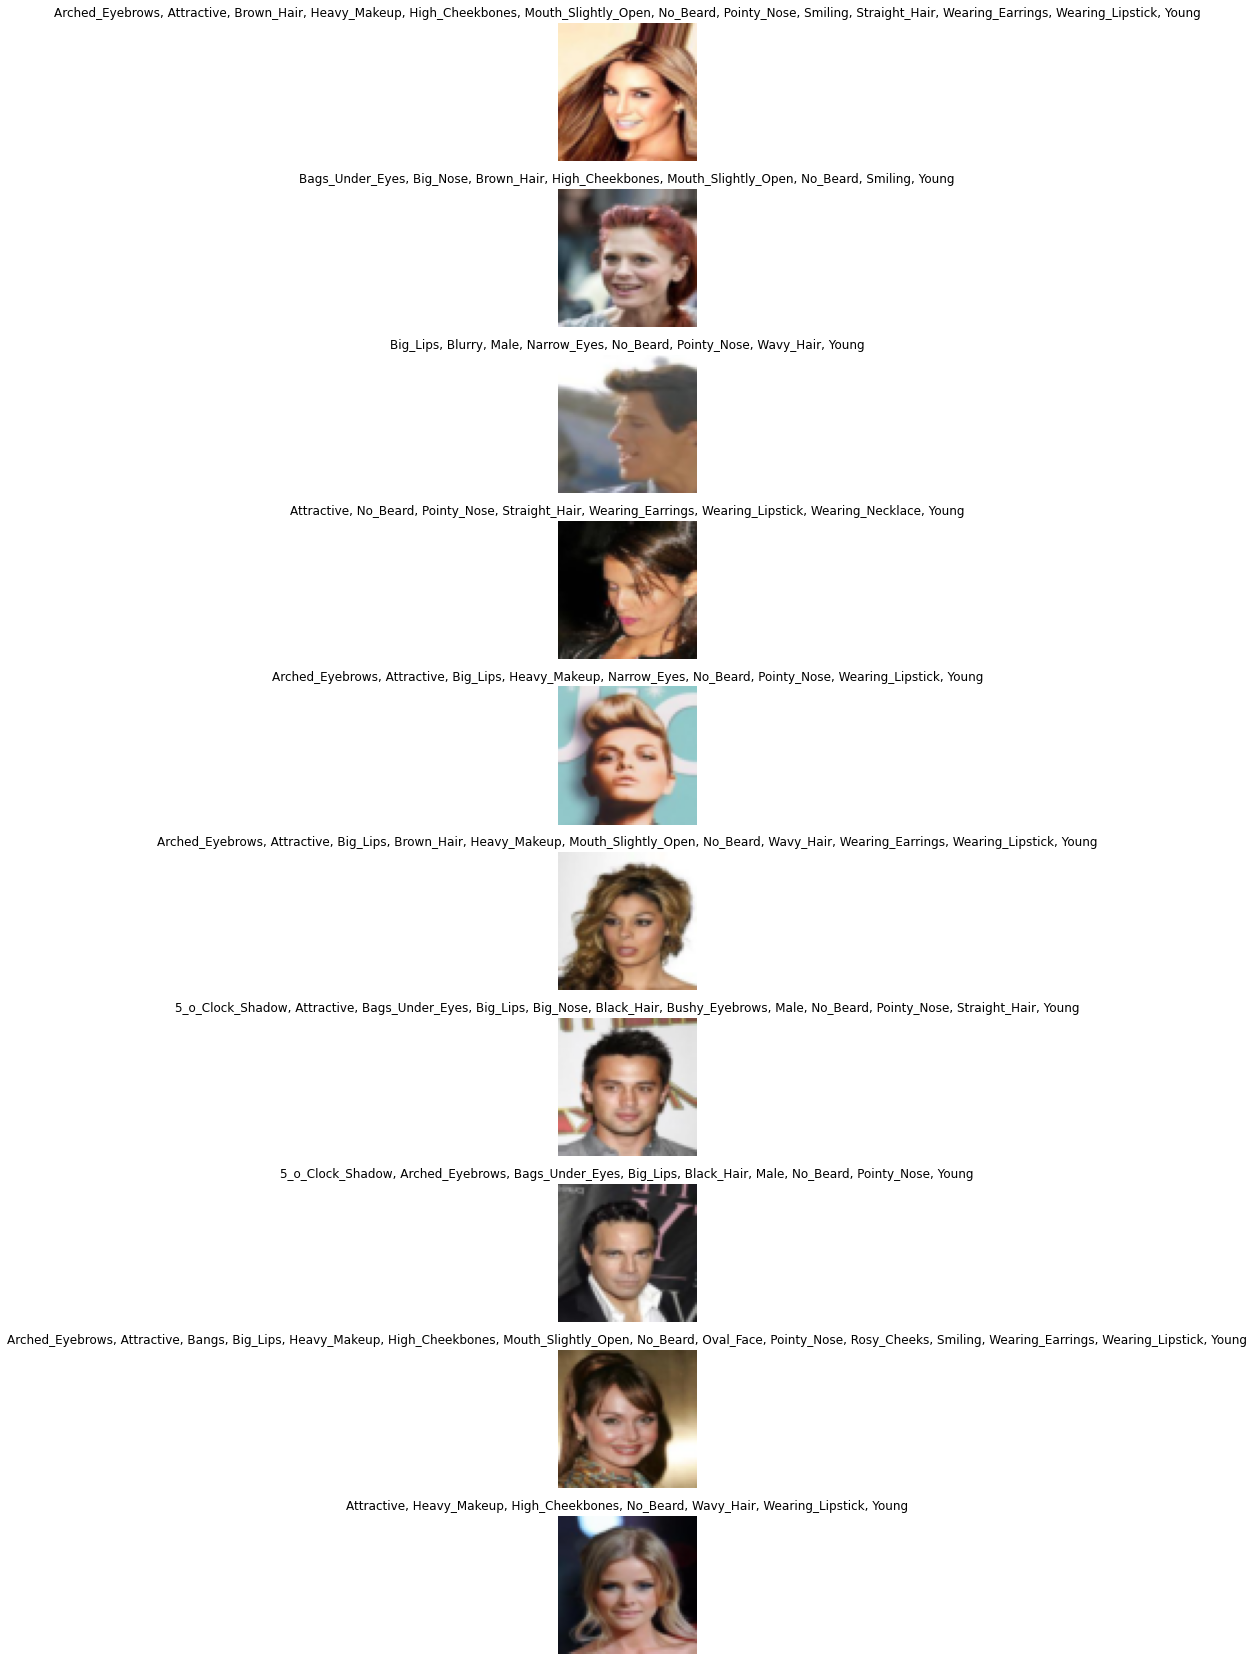

In [11]:
plt.figure(figsize=(30, 30))
for index, (image, attr) in enumerate(celeba):
    if index >= 10: break
    plt.subplot(10, 1, index+1)
    plt.imshow((image.squeeze().permute(1, 2, 0) + 1) / 2)
    plt.title(', '.join([index2attr[att_i] for att_i, att_val in enumerate(attr.view(-1)) if att_val == 1]))
    plt.axis('off')

plt.show()

В этой домашней работе вам предлагается повторить результаты статьи StarGAN (https://arxiv.org/abs/1711.09020). 

Основная часть домашнего задания - чтение статьи и улучшение результатов, поэтому обязательно прочитайте не только StarGAN, но и другие Image-to-Image GAN подходы того времени (17-18 год) 


In [12]:
import wandb

project = 'GM HW2'

## Задача 1 (0.4 балла):

Повторить результаты StarGAN используя только CelebA

что это значит: в статье предлагается способ использовать несколько датасетов и выучивание аттрибутов уникальных для какого-то одного датасета. Мы не просим вас это делать, вам достаточно просто обучить StarGAN на CelebA

In [13]:
# Simple function for wandb logging
import random
from calculate_fid import calculate_fid

def generate_example(model, loader):
    model.eval()

    rand_index = random.randrange(len(loader.dataset))
    image, label = loader.dataset[rand_index]
    
    device = model.device
    image, label = image.to(device).unsqueeze(0), label.to(device).unsqueeze(0)
    
    label = label[:, labels_idx]
    new_label = label.clone()
    i = random.choice(np.arange(len(new_label[0])))
    new_label[:, i] ^= 1 
    
    
    with torch.no_grad():
        reconstructed_image = model.generate(image, label).squeeze(0)
        new_image = model.generate(image, new_label).squeeze(0)

    # old_caption = [index2attr[labels_idx[i]] for i in range(5) if label[0][i] != 0]
    # new_caption = [index2attr[labels_idx[i]] for i in range(5) if new_label[0][i] != 0] 
    
    image, label = image.squeeze(0), label.squeeze(0)
    
    image = ((image.permute(1, 2, 0) + 1) / 2).cpu().numpy()
    reconstructed_image = ((reconstructed_image.permute(1, 2, 0) + 1) / 2).cpu().numpy()
    new_image = ((new_image.permute(1, 2, 0) + 1) / 2).cpu().numpy()

    example = {'input image': wandb.Image(image),
               'reconstructed image': wandb.Image(reconstructed_image),
               'new image': wandb.Image(new_image)
               }
    
    return example

def train(epoch, loader, model, n_disc=1):
    d_losses = []
    g_losses = []
    model.train()
    device = model.device
    for i, (image, label) in tqdm(enumerate(loader), desc=f"trainloop: {epoch}", leave=False):
        image, label = image.to(device), label.to(device)
        label = label[:, labels_idx]
        new_label = permute_labels(label)

        for _ in range(n_disc):
            d_loss = model.trainD(image, label, new_label)
        
        g_loss = model.trainG(image, label, new_label)
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (i + 1) % 150 == 0:
            example = generate_example(model, loader)
            g_train_loss = np.mean(g_losses)
            d_train_loss = np.mean(d_losses)
            d_losses = []
            g_losses = []
                    
            example.update({'G loss': g_train_loss,
                            'D loss': d_train_loss
                            })
            
            if (i + 1) % 600 == 0:
                fid = calculate_fid(celeba_val_dataloader, model, fid_model, labels_idx)

                example.update({'FID': fid
                                })

            wandb.log(example)

            model.train()
            torch.save(model.G.state_dict(), PATH + name + "_generator.pt")
            torch.save(model.D.state_dict(), PATH + name + "_critic.pt")


In [14]:
from model import StarGAN
from utils import permute_labels

labels_idx = np.arange(40)
labels_idx = [4, 8, 9, 11, 17, 20, 31 ,35, 39] # bald, black, blond, brown, grey, male, smile, hat, young

model = StarGAN(device, d_n_layers=2, g_n_layers=2, c_dim=len(labels_idx), image_size=64)
PATH = "/content/drive/MyDrive/"

In [18]:
name = 'Unet_FID' 
load = True

if load:
    checkpoint_g = torch.load(PATH + name + '_generator.pt')
    model.G.load_state_dict(checkpoint_g)
    checkpoint_d = torch.load(PATH + name + '_critic.pt')
    model.D.load_state_dict(checkpoint_d)

In [ ]:



wandb.init(project=project, name=name);
# wandb.watch(model);

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1458, in _atexit_cleanup
    self._on_finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1615, in _on_finish
    self._backend.interface.publish_telemetry(self._telemetry_obj)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 226, in publish_telemetry
    self._publish(rec)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 518, in _publish
    raise Exception("The wandb backend process has shutdown")
Exception: The wandb backend process has shutdown


In [ ]:
from inception import InceptionV3

fid_model = InceptionV3().to(device)

epochs = 10
for i in range(1, epochs + 1):
    train(i, celeba_dataloader, model)

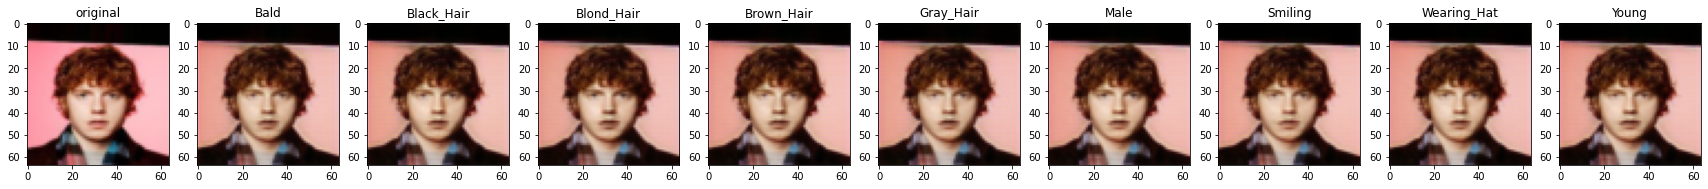

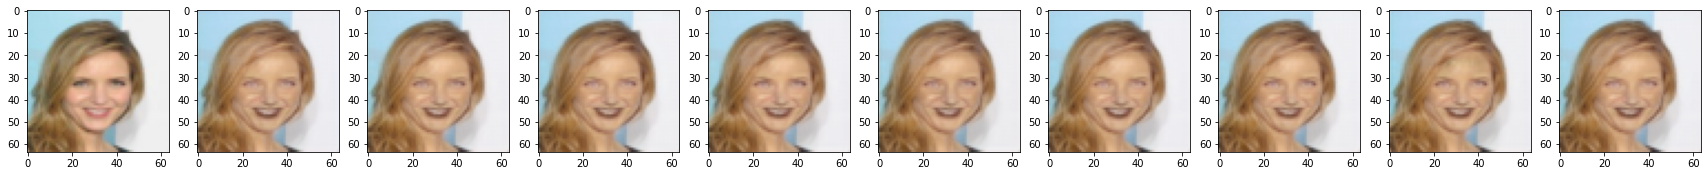

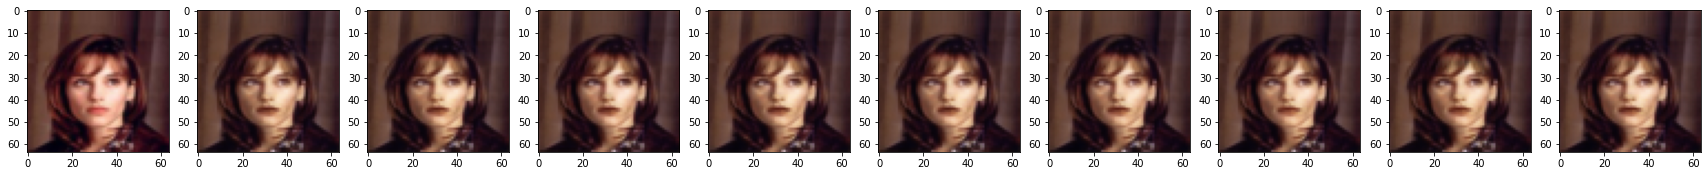

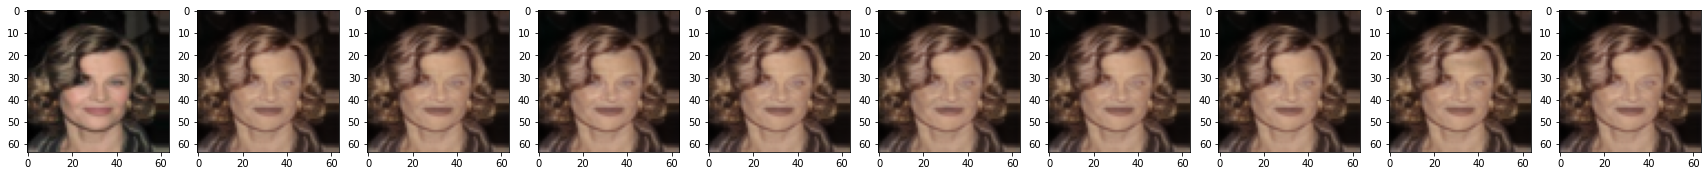

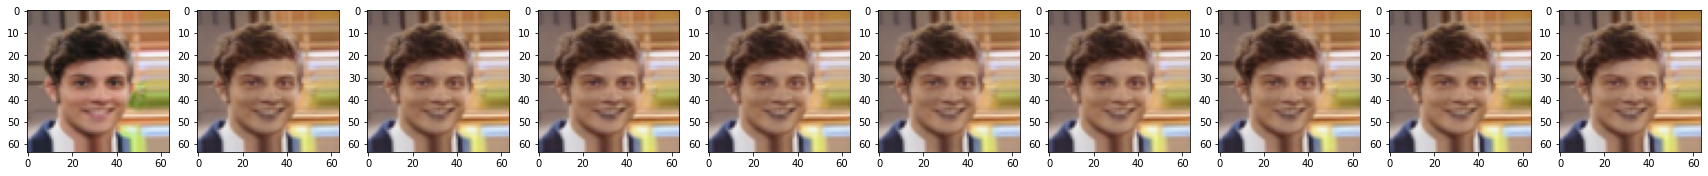

In [23]:
model.eval()
for ind, (image, label) in enumerate(celeba_val_dataloader): # batch = 1
    if ind >= 5: 
        break
    plt.figure(figsize=(30, 6))
    
    label = label[0][labels_idx]
    k = len(label)
    
    plt.subplot(1, k + 1, 1)
    if (ind <= 0):
        plt.title('original')
    plt.imshow((image[0].permute(1, 2, 0) + 1) / 2)
    for i in range(len(label)):
        new_label = label.clone()
        new_label[i] ^= 1
        plt.subplot(1, k + 1, i + 2)
        fake_image = model.generate(image.to(device), new_label.unsqueeze(0).to(device)).detach().cpu()[0]
        if (ind <= 0):
            caption = index2attr[labels_idx[i]]
            plt.title(caption)
        plt.imshow((fake_image.permute(1, 2, 0) + 1) / 2)
        

plt.savefig('picture.pdf')

Качество на глаз сравнил, вроде кайф.

## Важно 4: 

Если вы учите на колабе или на наших машинках, вероятнее всего что обучение будет очень долгим на картинках 256х256. Никто не мешает уменьшить разрешение, главное чтобы было видно что трансформации выучились

Еще, кажется что не все аттрибуты селебы являются очень важными или достаточно представленными в датасете. Не запрещается убирать бесполезные аттрибуты (только обоснуйте почему так сделали в отчете)

Не забывайте про аугментации

## Важно 5: 

Да, мы знаем что в на гитхабе лежить готовый код на путорче для этой статьи. Проблема в том что он написал на torch 0.4, поэтому, если мы увидим что вы используете __старый__ код со старыми модулями, то мы:

1. Будем неодобрительно смотреть
2. За наглое списывание будем снимать баллы


## Задача 2 (0.2 балла): 

Мерить качество на глаз - плохая идея. Подключите подсчет FID для каждой N эпохи, чтобы вы могли следить за прогрессом модели.

Сранение моделей между собой тоже возможно только по FID, поэтому трекайте его когда будете делать другие эксперименты

## Задача 3 (0.4 балла):

Если вы будете дословно повторять архитектуру авторов статьи, вы сразу же увидите что обучение станет дико долгим и не очень стабильным. Возможно у вас получится предложить несколько улучшений, которые приведут к хорошему FID, к визуально лучшим результатам или к более стабильному обучению.

В этой задаче хочется чтобы вы попробовали улучшить результаты статьи используя либо то что уже знаете, либо что-то из релевантных статей по Im2Im современности

## Важно 6: 

Когда вы будете показывать визуальные трансформации которые делает ваш StarGAN, хорошей идеей будет сразу же зафиксировать набор картинок (очевидно из валидации) и набор трансформаций на которых вы будете показывать результаты. Например: 10 картинок разных людей на которых вы покажете Male-Female, Beard-noBeard, Old-Young трансформации

## Важно 7 (0.15 балла): 

Выдам дополнительные баллы если у вас получится визуально красивая перекраска волос в разные цвета